# Gemini GSAOI reduction using DRAGONS Python API
***
## Public archival data from gsaoiimg_tutorial - GS-2017A-Q-29 (NGC5128)
#### adapted from https://gsaoiimg-drtutorial.readthedocs.io/en/v2.1.1/03_api_reduction.html
#### don't forget to `conda install -n dragons nb_conda_kernels ipykernel` to run this notebook on the DRAGONS env
***

**Importing Python Libraries** (you'll probably have to install the `wget`, `disco_stu`, and `ipympl` libraries)

In [50]:
from __future__ import print_function

import glob
import wget

from gempy.adlibrary import dataselect
from recipe_system import cal_service
from recipe_system.reduction.coreReduce import Reduce
from gempy.utils import logutils

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.colors import PowerNorm

from collections import namedtuple

from disco_stu import disco
from disco_stu.lookups import general_parameters as disco_pars

#%matplotlib widget
%matplotlib inline

**Downloading the data** (direct link to .tar file hosted at Gemini - 960 Megabytes)

In [4]:
#wget.download("http://www.gemini.edu/sciops/data/software/datapkgs/gsaoiimg_tutorial_datapkg-v1.tar")

**Downloading the data** (individual files - direct link to the Gemini Archive - 3.0 Gigabytes)

In [5]:
# Science 
#
#wget.download("http://archive.gemini.edu/file/S20170505S0095.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0096.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0097.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0098.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0099.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0100.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0101.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0102.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0103.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0104.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0105.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0106.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0107.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0108.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0109.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0110.fits")

# Flats 
#
#wget.download("http://archive.gemini.edu/file/S20170505S0030.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0031.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0032.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0033.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0034.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0035.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0036.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0037.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0038.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0039.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0040.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0041.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0042.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0043.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0044.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0060.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0061.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0062.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0063.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0064.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0065.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0066.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0067.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0068.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0069.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0070.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0071.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0072.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0073.fits")
#wget.download("http://archive.gemini.edu/file/S20170505S0074.fits")

# Standard star
#
#wget.download("http://archive.gemini.edu/file/S20170504S0114.fits")
#wget.download("http://archive.gemini.edu/file/S20170504S0115.fits")
#wget.download("http://archive.gemini.edu/file/S20170504S0116.fits")
#wget.download("http://archive.gemini.edu/file/S20170504S0117.fits")



**Create and move data to raw/ directory** (uncomment first)

In [6]:
#!mkdir raw/
#!mv S2017*.fits raw/

In [95]:
# Check header of one raw science image
#
tmp = fits.open("raw/S20170505S0095.fits")
tmp[0].header

**Setting up the DRAGONS logger**

In [7]:
logutils.config(file_name='gsaoi_data_reduction.log')

**Setting up the Calibration Service**

First, check that you have already a `rsys.cfg` file inside the `~/.geminidr/`. It should contain:

```[calibs]
standalone = True
database_dir = /path_to_this_folder/```

In [8]:
caldb = cal_service.CalibrationService()
caldb.config()
caldb.init()

cal_service.set_calservice()

CalibrationService is configured as standalone.
The configured local database will be used.


**Create a list of all the FITS files in the directory**

In [10]:
all_files = glob.glob('raw/S2017*[0-9].fits')
all_files.sort()
#all_files

**List of flats, standard star, and science frames**

In [11]:
list_of_flats_Ks = dataselect.select_data(
     all_files,['FLAT'],[],
     dataselect.expr_parser('filter_name=="Kshort"'))

list_of_std_stars = dataselect.select_data(
    all_files,[],[],
    dataselect.expr_parser('observation_class=="partnerCal"'))

list_of_science_images = dataselect.select_data(
    all_files,[],[],
    dataselect.expr_parser('(observation_class=="science" and exposure_time==60.)'))

**Create Master Flat Field and add to the calibration database**

In [12]:
reduce_flats = Reduce()
reduce_flats.files.extend(list_of_flats_Ks)
reduce_flats.runr()

caldb.add_cal(reduce_flats.output_filenames[0])

All submitted files appear valid:
raw/S20170505S0030.fits ... raw/S20170505S0074.fits, 30 files submitted.
RECIPE: _default
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Upd

      S20170505S0060_prepared.fits is not affected by latency
      S20170505S0061_prepared.fits affected by S20170505S0060_latencyAdded.fits
      S20170505S0062_prepared.fits affected by S20170505S0060_latencyAdded.fits,S20170505S0061_latencyAdded.fits
      S20170505S0063_prepared.fits affected by S20170505S0060_latencyAdded.fits,S20170505S0061_latencyAdded.fits,S20170505S0062_latencyAdded.fits
      S20170505S0064_prepared.fits affected by S20170505S0060_latencyAdded.fits,S20170505S0061_latencyAdded.fits,S20170505S0062_latencyAdded.fits,S20170505S0063_latencyAdded.fits
      S20170505S0065_prepared.fits affected by S20170505S0060_latencyAdded.fits,S20170505S0061_latencyAdded.fits,S20170505S0062_latencyAdded.fits,S20170505S0063_latencyAdded.fits,S20170505S0064_latencyAdded.fits
      S20170505S0066_prepared.fits affected by S20170505S0060_latencyAdded.fits,S20170505S0061_latencyAdded.fits,S20170505S0062_latencyAdded.fits,S20170505S0063_latencyAdded.fits,S20170505S0064_latencyAdded.f

      nonlinearity correction for EXTVER 3 is (0.9947278, 7.067051e-07, 2.177223e-11)
      nonlinearity correction for EXTVER 4 is (0.9958842, 5.670857e-07, 2.718377e-11)
   Applying nonlinearity correction to S20170505S0040_dqAdded.fits
      nonlinearity correction for EXTVER 1 is (0.9947237, 7.400241e-07, 2.539787e-11)
      nonlinearity correction for EXTVER 2 is (0.9944842, 6.748257e-07, 3.67996e-11)
      nonlinearity correction for EXTVER 3 is (0.9947278, 7.067051e-07, 2.177223e-11)
      nonlinearity correction for EXTVER 4 is (0.9958842, 5.670857e-07, 2.718377e-11)
   Applying nonlinearity correction to S20170505S0041_dqAdded.fits
      nonlinearity correction for EXTVER 1 is (0.9947237, 7.400241e-07, 2.539787e-11)
      nonlinearity correction for EXTVER 2 is (0.9944842, 6.748257e-07, 3.67996e-11)
      nonlinearity correction for EXTVER 3 is (0.9947278, 7.067051e-07, 2.177223e-11)
      nonlinearity correction for EXTVER 4 is (0.9958842, 5.670857e-07, 2.718377e-11)
   Apply

      nonlinearity correction for EXTVER 3 is (0.9947278, 7.067051e-07, 2.177223e-11)
      nonlinearity correction for EXTVER 4 is (0.9958842, 5.670857e-07, 2.718377e-11)
   .
   PRIMITIVE: ADUToElectrons
   -------------------------
   Converting S20170505S0030_nonlinearityCorrected.fits from ADU to electrons by multiplying by the gain
     gain for EXTVER 1 = 2.434
     gain for EXTVER 2 = 2.01
     gain for EXTVER 3 = 2.411
     gain for EXTVER 4 = 2.644
   Converting S20170505S0031_nonlinearityCorrected.fits from ADU to electrons by multiplying by the gain
     gain for EXTVER 1 = 2.434
     gain for EXTVER 2 = 2.01
     gain for EXTVER 3 = 2.411
     gain for EXTVER 4 = 2.644
   Converting S20170505S0032_nonlinearityCorrected.fits from ADU to electrons by multiplying by the gain
     gain for EXTVER 1 = 2.434
     gain for EXTVER 2 = 2.01
     gain for EXTVER 3 = 2.411
     gain for EXTVER 4 = 2.644
   Converting S20170505S0033_nonlinearityCorrected.fits from ADU to electrons by 

           S20170505S0044_varAdded.fits
         .
         PRIMITIVE: showInputs
         ---------------------
         Inputs for lampOff
           S20170505S0060_varAdded.fits
           S20170505S0061_varAdded.fits
           S20170505S0062_varAdded.fits
           S20170505S0063_varAdded.fits
           S20170505S0064_varAdded.fits
           S20170505S0065_varAdded.fits
           S20170505S0066_varAdded.fits
           S20170505S0067_varAdded.fits
           S20170505S0068_varAdded.fits
           S20170505S0069_varAdded.fits
           S20170505S0070_varAdded.fits
           S20170505S0071_varAdded.fits
           S20170505S0072_varAdded.fits
           S20170505S0073_varAdded.fits
           S20170505S0074_varAdded.fits
         .
         PRIMITIVE: stackFrames
         ----------------------
         Combining EXTVER 1.
         
         Combining EXTVER 2.
         
         Combining EXTVER 3.
         
         Combining EXTVER 4.
         
         .
         PRIMITIV

**Reduce Standard Star**

In [13]:
reduce_std = Reduce()
reduce_std.files.extend(list_of_std_stars)
reduce_std.runr()

All submitted files appear valid:
raw/S20170504S0114.fits ... raw/S20170504S0117.fits, 4 files submitted.
RECIPE: _default
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GSAOI
         Updating the CCDSEC for central ROI data
         Updating the CCDSEC for central ROI dat

     S20170504S0114_skyAssociated.fits
     S20170504S0115_skyAssociated.fits
     S20170504S0116_skyAssociated.fits
   .
   PRIMITIVE: skyCorrect
   ---------------------
   Creating sky frame for S20170504S0114_skyAssociated.fits
      PRIMITIVE: stackSkyFrames
      -------------------------
         PRIMITIVE: stackFrames
         ----------------------
         Combining EXTVER 1. Applying offsets.
         S20170504S0115_skyAssociated.fits            0.000
         S20170504S0116_skyAssociated.fits           -1.208
         S20170504S0117_skyAssociated.fits           10.729
         
         Combining EXTVER 2. Applying offsets.
         S20170504S0115_skyAssociated.fits            0.000
         S20170504S0116_skyAssociated.fits            8.736
         S20170504S0117_skyAssociated.fits           11.748
         
         Combining EXTVER 3. Applying offsets.
         S20170504S0115_skyAssociated.fits            0.000
         S20170504S0116_skyAssociated.fits            6.982

         S20170504S0115_objectMaskAdded.fits          0.000
         S20170504S0116_objectMaskAdded.fits          6.583
         S20170504S0117_objectMaskAdded.fits         10.200
         
         Combining EXTVER 3. Applying offsets.
         S20170504S0115_objectMaskAdded.fits          0.000
         S20170504S0116_objectMaskAdded.fits          7.750
         S20170504S0117_objectMaskAdded.fits         10.422
         
         Combining EXTVER 4. Applying offsets.
         S20170504S0115_objectMaskAdded.fits          0.000
         S20170504S0116_objectMaskAdded.fits          7.370
         S20170504S0117_objectMaskAdded.fits          8.626
         
         .
      .
   Creating sky frame for S20170504S0115_objmaskDilated.fits
      PRIMITIVE: stackSkyFrames
      -------------------------
         PRIMITIVE: addObjectMaskToDQ
         ----------------------------
         .
         PRIMITIVE: stackFrames
         ----------------------
         Combining EXTVER 1. Applying off

**Reduce Science Images**

In [16]:
reduce_target = Reduce()
reduce_target.files.extend(list_of_science_images)
reduce_target.uparms.append(('skyCorrect:offset_sky', False))
reduce_target.runr()

All submitted files appear valid:
raw/S20170505S0095.fits ... raw/S20170505S0110.fits, 16 files submitted.
RECIPE: _default
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Upd

      nonlinearity correction for EXTVER 2 is (0.9944842, 6.748257e-07, 3.67996e-11)
      nonlinearity correction for EXTVER 3 is (0.9947278, 7.067051e-07, 2.177223e-11)
      nonlinearity correction for EXTVER 4 is (0.9958842, 5.670857e-07, 2.718377e-11)
   Applying nonlinearity correction to S20170505S0102_dqAdded.fits
      nonlinearity correction for EXTVER 1 is (0.9947237, 7.400241e-07, 2.539787e-11)
      nonlinearity correction for EXTVER 2 is (0.9944842, 6.748257e-07, 3.67996e-11)
      nonlinearity correction for EXTVER 3 is (0.9947278, 7.067051e-07, 2.177223e-11)
      nonlinearity correction for EXTVER 4 is (0.9958842, 5.670857e-07, 2.718377e-11)
   Applying nonlinearity correction to S20170505S0103_dqAdded.fits
      nonlinearity correction for EXTVER 1 is (0.9947237, 7.400241e-07, 2.539787e-11)
      nonlinearity correction for EXTVER 2 is (0.9944842, 6.748257e-07, 3.67996e-11)
      nonlinearity correction for EXTVER 3 is (0.9947278, 7.067051e-07, 2.177223e-11)
      non

         Received calibration request for S20170505S0098_varAdded.fits
         Received calibration request for S20170505S0099_varAdded.fits
         Received calibration request for S20170505S0100_varAdded.fits
         Received calibration request for S20170505S0101_varAdded.fits
         Received calibration request for S20170505S0102_varAdded.fits
         Received calibration request for S20170505S0103_varAdded.fits
         Received calibration request for S20170505S0104_varAdded.fits
         Received calibration request for S20170505S0105_varAdded.fits
         Received calibration request for S20170505S0106_varAdded.fits
         Received calibration request for S20170505S0107_varAdded.fits
         Received calibration request for S20170505S0108_varAdded.fits
         Received calibration request for S20170505S0109_varAdded.fits
         Received calibration request for S20170505S0110_varAdded.fits
         LOCAL CALIBRATION SEARCH:
         Cached calibration calibrations/p

         ----------------------
         Combining EXTVER 1. Applying offsets.
         S20170505S0104_skyAssociated.fits            0.000
         S20170505S0106_skyAssociated.fits          -37.529
         S20170505S0107_skyAssociated.fits           -2.132
         S20170505S0108_skyAssociated.fits           68.222
         S20170505S0109_skyAssociated.fits           91.196
         S20170505S0110_skyAssociated.fits          101.548
         
         Combining EXTVER 2. Applying offsets.
         S20170505S0104_skyAssociated.fits            0.000
         S20170505S0106_skyAssociated.fits          -39.164
         S20170505S0107_skyAssociated.fits           -1.449
         S20170505S0108_skyAssociated.fits           68.899
         S20170505S0109_skyAssociated.fits           95.599
         S20170505S0110_skyAssociated.fits          102.570
         
         Combining EXTVER 3. Applying offsets.
         S20170505S0104_skyAssociated.fits            0.000
         S20170505S0106_sky

         PRIMITIVE: stackFrames
         ----------------------
         Combining EXTVER 1. Applying offsets.
         S20170505S0104_skyAssociated.fits            0.000
         S20170505S0105_skyAssociated.fits          -12.687
         S20170505S0106_skyAssociated.fits          -37.529
         S20170505S0107_skyAssociated.fits           -2.132
         S20170505S0108_skyAssociated.fits           68.222
         S20170505S0110_skyAssociated.fits          101.548
         
         Combining EXTVER 2. Applying offsets.
         S20170505S0104_skyAssociated.fits            0.000
         S20170505S0105_skyAssociated.fits          -10.857
         S20170505S0106_skyAssociated.fits          -39.164
         S20170505S0107_skyAssociated.fits           -1.449
         S20170505S0108_skyAssociated.fits           68.899
         S20170505S0110_skyAssociated.fits          102.570
         
         Combining EXTVER 3. Applying offsets.
         S20170505S0104_skyAssociated.fits            0

         ----------------------------
         .
         PRIMITIVE: stackFrames
         ----------------------
         Combining EXTVER 1. Applying offsets.
         S20170505S0104_objectMaskAdded.fits          0.000
         S20170505S0105_objectMaskAdded.fits        -12.670
         S20170505S0106_objectMaskAdded.fits        -37.461
         
         Combining EXTVER 2. Applying offsets.
         S20170505S0104_objectMaskAdded.fits          0.000
         S20170505S0105_objectMaskAdded.fits        -10.851
         S20170505S0106_objectMaskAdded.fits        -39.652
         
         Combining EXTVER 3. Applying offsets.
         S20170505S0104_objectMaskAdded.fits          0.000
         S20170505S0105_objectMaskAdded.fits         -9.070
         S20170505S0106_objectMaskAdded.fits        -33.802
         
         Combining EXTVER 4. Applying offsets.
         S20170505S0104_objectMaskAdded.fits          0.000
         S20170505S0105_objectMaskAdded.fits         -6.020
         

	Wrote S20170505S0101_skySubtracted.fits in output directory
	Wrote S20170505S0102_skySubtracted.fits in output directory
	Wrote S20170505S0103_skySubtracted.fits in output directory

reduce completed successfully.


**Stack Sky-subtracted Images** (using `disco_stu` on the command line and not the API)

In [79]:
!disco `dataselect *_skySubtracted.fits --expr='observation_class=="science"'`
#!disco `dataselect *_skySubtracted.fits --expr='observation_class=="partnerCal"'`

    Disco-Stu will reduce your data for you.
    Reading input files and running source detection...
    Found 13 sources in S20170504S0114_skySubtracted
    Found 8 sources in S20170504S0115_skySubtracted
    Found 7 sources in S20170504S0116_skySubtracted
    Found 9 sources in S20170504S0117_skySubtracted
    Matching sources...
    Aligning all images to S20170504S0114_skySubtracted...
    Matched 5 sources between S20170504S0115_skySubtracted and S20170504S0114_skySubtracted
    Matched 4 sources between S20170504S0116_skySubtracted and S20170504S0114_skySubtracted
    Matched 6 sources between S20170504S0117_skySubtracted and S20170504S0114_skySubtracted
    Updating object catalogs...
    Calculating the output projection...
    Output image will be 5599 x 5698 pixels
    Applying transform for S20170504S0114_skySubtracted
    Writing S20170504S0114_skySubtracted_proj to disk
    Applying transform for S20170504S0115_skySubtracted
    Writing S20170504S0115_skySubtracted_proj to

**Display the Stacked Image**

In [86]:
image_file = "disco_stack_science.fits"
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: disco_stack_science.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     319   ()      
  1  SCI           1 ImageHDU       118   (4370, 4337)   float32   
  2  VAR           1 ImageHDU       118   (4370, 4337)   float32   
  3  DQ            1 ImageHDU       118   (4370, 4337)   int16   


In [87]:
image_data = fits.getdata(image_file, ext=1)
print(image_data.shape)

(4337, 4370)


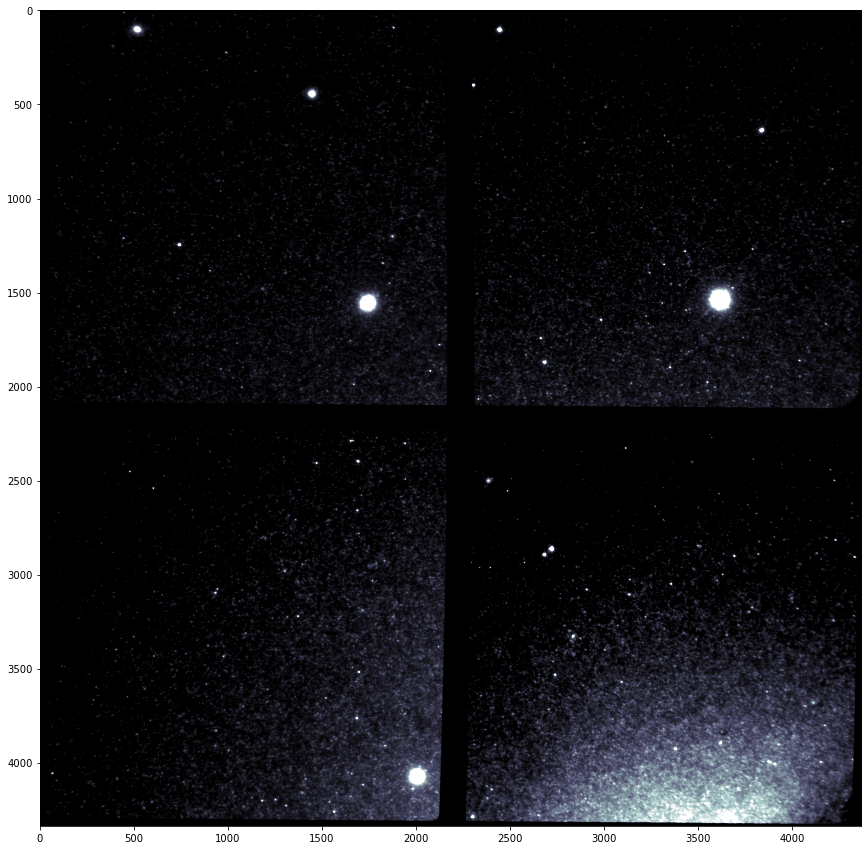

In [99]:
plt.figure(figsize = (15,15))
plt.imshow(image_data,cmap='bone',norm=Normalize(vmin=1, vmax=1000))
#plt.xlim(900,2500)
#plt.ylim(1600,600)
plt.show()

**Optional: remove duplicate calibrations and remove raw data (uncomment lines before running)**

In [79]:
#!rm -rf *_flatCorrected.fits *_skySubtracted*.fits
#!rm -rf raw/